In [1]:
import os
import csv
import math
import itertools

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from scipy import sparse
import networkx as nx

from mbi import (
    Dataset,
    FactoredInference,
    Domain,
    LocalInference,
    MixtureInference,
    PublicInference,
)

In [2]:
data = Dataset.load("data/german_processed.csv", "data/german_processed.json")

In [3]:
N = data.df.shape[0]
df = pd.DataFrame(columns=['col1','col2', 'score'])
idx = 0

In [4]:
# source: https://github.com/usnistgov/PrivacyEngCollabSpace/blob/master/tools/de-identification/Differential-Privacy-Synthetic-Data-Challenge-Algorithms/rmckenna/select-queries.ipynb

# calculate mutual info between every pair of attributes

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    # print(a,b,score)
    df.loc[idx] = [a,b,score]
    df.loc[idx+1] = [b,a,score]
    idx += 2

df = df.sort_values('score')


/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/1968762910.py:11: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/1968762910.py:11: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/1968762910.py:11: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())

In [5]:
df.head()

,col1,col2,score
24,Sex,Checking account,0.000372
25,Checking account,Sex,0.000372
46,Job,Risk,0.000927
47,Risk,Job,0.000927
23,Saving accounts,Sex,0.002248


In [6]:
nodes = data.domain.attrs
weights = df[df.col1.isin(nodes) & df.col2.isin(nodes)]
weights.head()

,col1,col2,score
24,Sex,Checking account,0.000372
25,Checking account,Sex,0.000372
46,Job,Risk,0.000927
47,Risk,Job,0.000927
23,Saving accounts,Sex,0.002248


In [7]:
G = nx.Graph()
G.add_nodes_from(nodes)

for e1, e2, w in zip(weights['col1'], weights['col2'], weights['score']):
    G.add_edge(e1, e2, weight=w)

mst = nx.maximum_spanning_tree(G)

es = list(mst.edges)
print(es)
print(len(es))

[('Age', 'Credit amount'), ('Sex', 'Credit amount'), ('Job', 'Credit amount'), ('Housing', 'Credit amount'), ('Saving accounts', 'Credit amount'), ('Checking account', 'Credit amount'), ('Credit amount', 'Duration'), ('Credit amount', 'Purpose'), ('Credit amount', 'Risk')]
9


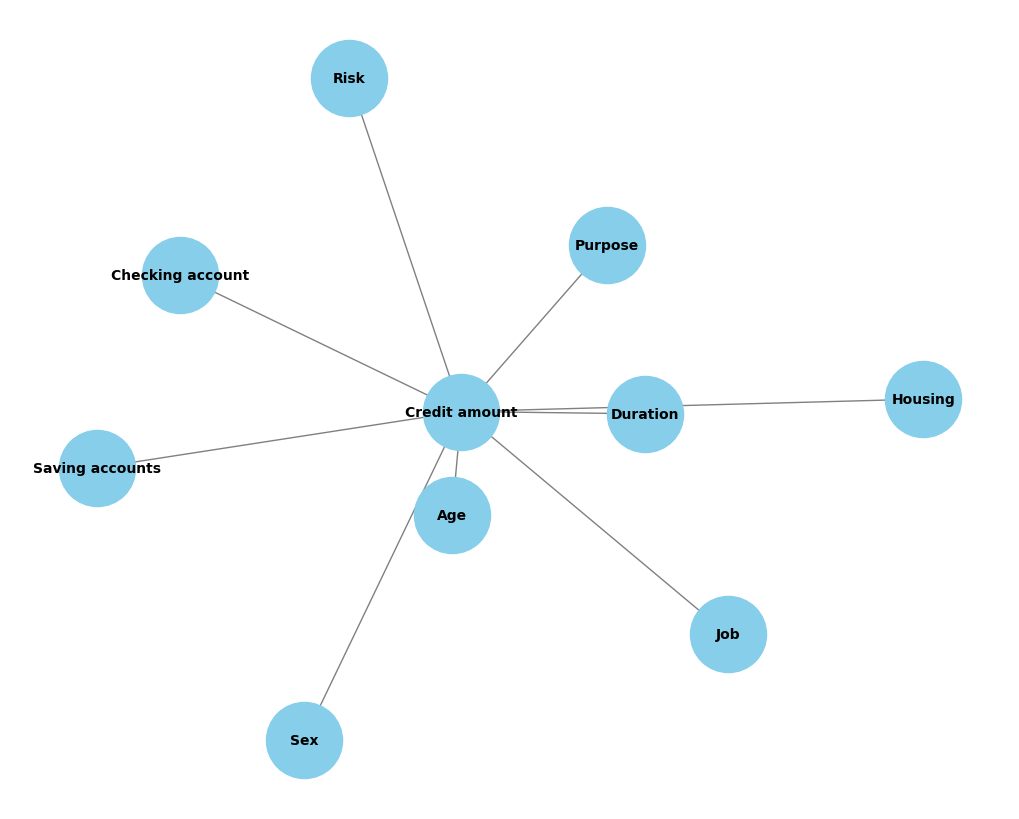

In [8]:
plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(mst, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()

In [9]:
df = pd.DataFrame(columns=['col1','col2', 'score', 'bound'])
idx = 0

entropies = {key: -1 for key in data.domain.attrs}

for attr in data.domain.attrs:
    # Calculate probabilities
    probabilities = data.df[attr].value_counts(normalize=True)
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    entropies[attr] = entropy

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    df.loc[idx] = [a,b,score,min(entropies[a],entropies[b])]
    idx += 1

df = df.sort_values('score')

df = df[df['score'] > df['bound'] * 0.1]
df

/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/2559294257.py:20: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/2559294257.py:20: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38275/2559294257.py:20: RuntimeWarning: invalid value encountered in divide
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())

,col1,col2,score,bound
2,Age,Housing,0.131690,1.139012
6,Age,Duration,0.453121,3.764693
41,Credit amount,Risk,0.571002,0.881291
13,Sex,Credit amount,0.571783,0.893173
26,Housing,Credit amount,0.751026,1.139012
20,Job,Credit amount,0.918518,1.413405
31,Saving accounts,Credit amount,1.100353,1.687738
35,Checking account,Credit amount,1.177673,1.802043
40,Credit amount,Purpose,1.523031,2.331043
39,Credit amount,Duration,2.509829,3.764693


In [10]:
tuple_list = list(zip(df['col1'], df['col2']))
es.extend(tuple_list)
es = list(set(es))
print(es)
print(len(es))

[('Age', 'Duration'), ('Credit amount', 'Duration'), ('Checking account', 'Credit amount'), ('Sex', 'Credit amount'), ('Saving accounts', 'Credit amount'), ('Credit amount', 'Risk'), ('Age', 'Housing'), ('Age', 'Credit amount'), ('Job', 'Credit amount'), ('Housing', 'Credit amount'), ('Credit amount', 'Purpose')]
11


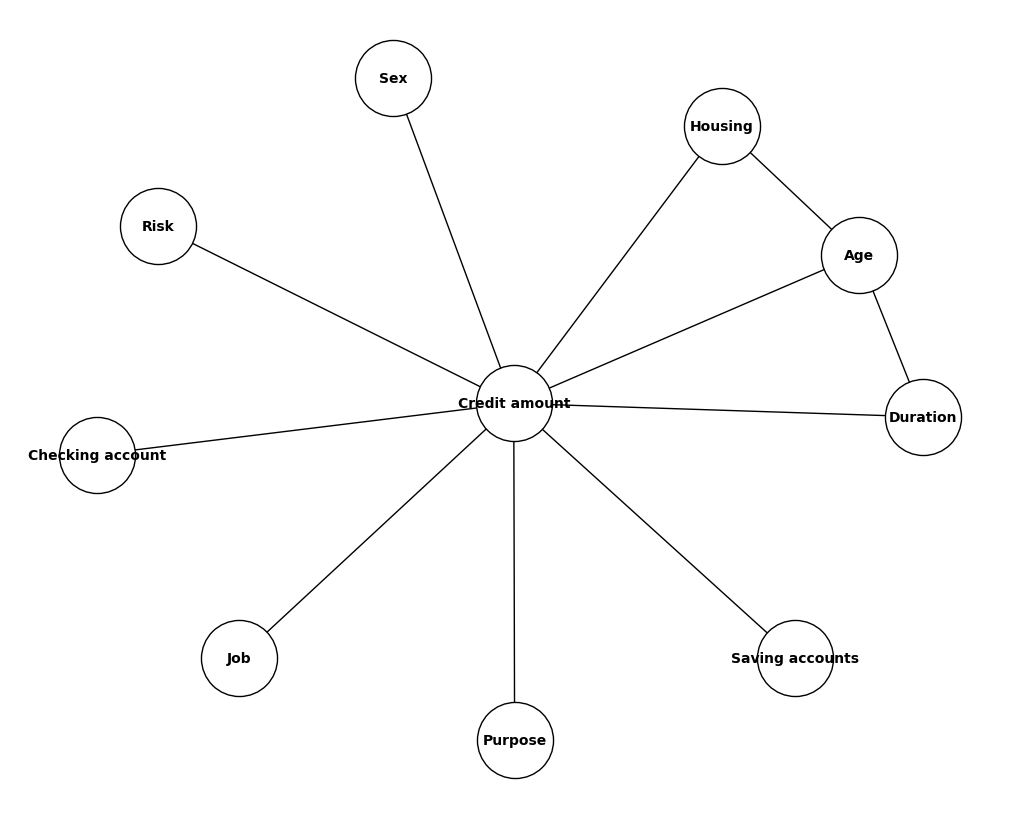

In [ ]:
# Create a directed graph
G = nx.Graph()

# Add edges to the graph
G.add_edges_from(es)

plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='white', node_size=3000, font_size=10, font_weight='bold', edge_color='black', node_shape='o', edgecolors='black')

# Save the figure as a PDF
plt.savefig("../paper/images/german_mst.pdf", format="pdf", bbox_inches='tight')  # Specify the format as PDF

# Show the plot
plt.show()

In [12]:
cliques = list(nx.find_cliques(G))
for c in cliques:
    print(c)

['Credit amount', 'Purpose']
['Credit amount', 'Job']
['Credit amount', 'Saving accounts']
['Credit amount', 'Risk']
['Credit amount', 'Sex']
['Credit amount', 'Checking account']
['Credit amount', 'Age', 'Housing']
['Credit amount', 'Age', 'Duration']
